<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
#Start Here
import spacy
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
df = pd.read_csv('.\data\Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [3]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [4]:
df = pd.DataFrame({
    'content': df['reviews.text'],
    'rating': df['reviews.rating'],
    'categories': df['categories'],
    'name': df['name']
})
df

,content,rating,categories
0,I order 3 of them and one of the item is bad q...,3,"AA,AAA,Health,Electronics,Health & Household,C..."
1,Bulk is always the less expensive way to go fo...,4,"AA,AAA,Health,Electronics,Health & Household,C..."
2,Well they are not Duracell but for the price i...,5,"AA,AAA,Health,Electronics,Health & Household,C..."
3,Seem to work as well as name brand batteries a...,5,"AA,AAA,Health,Electronics,Health & Household,C..."
4,These batteries are very long lasting the pric...,5,"AA,AAA,Health,Electronics,Health & Household,C..."
...,...,...,...
28327,I got 2 of these for my 8 yr old twins. My 11 ...,5,"Fire Tablets,Tablets,All Tablets,Amazon Tablet..."
28328,I bought this for my niece for a Christmas gif...,4,"Fire Tablets,Tablets,All Tablets,Amazon Tablet..."
28329,"Very nice for light internet browsing, keeping...",5,"Fire Tablets,Tablets,All Tablets,Amazon Tablet..."
28330,This Tablet does absolutely everything I want!...,5,"Fire Tablets,Tablets,All Tablets,Amazon Tablet..."


In [5]:
nlp = spacy.load("en_core_web_lg")

In [6]:
import re
# 1. Remove leading/trailing whitespace 
df['content'] = df['content'].apply(lambda c: c.strip())

# 2. Remove Emails
df['content'] = df['content'].apply(lambda c: re.sub('From: \S+@\S+', '', c))

# 3. Remove excessive (>1) whitespace characters
df['content'] = df['content'].apply(lambda c: re.sub('\s+', ' ', c))

# 4. Remove non-alphanumeric characters
df['content'] = df['content'].apply(lambda c: re.sub('[^0-9 a-zA-Z]+', '', c))

In [7]:
df

,content,rating,categories
0,I order 3 of them and one of the item is bad q...,3,"AA,AAA,Health,Electronics,Health & Household,C..."
1,Bulk is always the less expensive way to go fo...,4,"AA,AAA,Health,Electronics,Health & Household,C..."
2,Well they are not Duracell but for the price i...,5,"AA,AAA,Health,Electronics,Health & Household,C..."
3,Seem to work as well as name brand batteries a...,5,"AA,AAA,Health,Electronics,Health & Household,C..."
4,These batteries are very long lasting the pric...,5,"AA,AAA,Health,Electronics,Health & Household,C..."
...,...,...,...
28327,I got 2 of these for my 8 yr old twins My 11 y...,5,"Fire Tablets,Tablets,All Tablets,Amazon Tablet..."
28328,I bought this for my niece for a Christmas gif...,4,"Fire Tablets,Tablets,All Tablets,Amazon Tablet..."
28329,Very nice for light internet browsing keeping ...,5,"Fire Tablets,Tablets,All Tablets,Amazon Tablet..."
28330,This Tablet does absolutely everything I want ...,5,"Fire Tablets,Tablets,All Tablets,Amazon Tablet..."


In [8]:
conda install -c bjrn pandarallel

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda




In [9]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [14]:
# Creating lemmas column


df['lemmas'] = df['content'].apply(
    lambda c: [token.lemma_ for token in nlp(c) if (token.is_stop != True) and
               (token.is_punct != True)])

In [22]:
df['lemmas']

0        [order, 3, item, bad, quality, miss, backup, s...
1                    [bulk, expensive, way, product, like]
2                                 [Duracell, price, happy]
3                      [work, brand, battery, well, price]
4                      [battery, long, last, price, great]
                               ...                        
28327    [get, 2, 8, yr, old, twin, 11, yr, old, well, ...
28328    [buy, niece, Christmas, giftshe, 9, year, old,...
28329    [nice, light, internet, browse, keep, email, v...
28330    [Tablet, absolutely, want, watch, tv, show, mo...
28331    [ninety, dollar, expectionation, low, good, ta...
Name: lemmas, Length: 28332, dtype: object

In [24]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Create Dictionary
id2word = corpora.Dictionary(df['lemmas'] )

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

In [38]:
id2word[200]

'horrible'

In [39]:
df['content'][28330]

'This Tablet does absolutely everything I want I can watch TV Shows or Movies check my Mail Facebook Googlepay all my bills It processes fast and has a beautiful screen As I said Everything I want in a Tablet for less than 100'

In [40]:
corpus[28330]

[(93, 2),
 (142, 1),
 (150, 1),
 (211, 1),
 (252, 1),
 (610, 1),
 (1126, 1),
 (1207, 1),
 (1489, 1),
 (2083, 1),
 (2203, 1),
 (2537, 1),
 (4741, 1),
 (6589, 1),
 (7837, 2),
 (7869, 1),
 (9829, 1),
 (9830, 1)]

In [41]:
# Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[28330]]

[('want', 2),
 ('tv', 1),
 ('say', 1),
 ('100', 1),
 ('fast', 1),
 ('check', 1),
 ('process', 1),
 ('absolutely', 1),
 ('beautiful', 1),
 ('show', 1),
 ('screen', 1),
 ('watch', 1),
 ('bill', 1),
 ('movie', 1),
 ('Tablet', 2),
 ('Facebook', 1),
 ('Googlepay', 1),
 ('Mail', 1)]

In [42]:
%%time
lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=20, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=12)

Wall time: 23.6 s


In [43]:
lda_multicore.save('lda_multicore.model')

In [44]:
from gensim import models
lda_multicore =  models.LdaModel.load('lda_multicore.model')

In [46]:
from pprint import pprint
pprint(lda_multicore.print_topics())
doc_lda = lda_multicore[corpus]

[(0,
  '0.192*"fast" + 0.137*"awesome" + 0.121*"expect" + 0.092*"camera" + '
  '0.079*"model" + 0.039*"exactly" + 0.033*"regular" + 0.027*"describe" + '
  '0.024*"real" + 0.018*"well"'),
 (1,
  '0.134*"gift" + 0.096*"Christmas" + 0.072*"buy" + 0.033*"purchase" + '
  '0.029*"pleased" + 0.023*"previous" + 0.021*"ease" + 0.020*"unit" + '
  '0.019*"get" + 0.017*"husband"'),
 (2,
  '0.096*"charge" + 0.079*"child" + 0.066*"come" + 0.058*"not" + 0.041*"hold" '
  '+ 0.036*"case" + 0.034*"time" + 0.029*"know" + 0.027*"box" + 0.025*"4"'),
 (3,
  '0.056*"Fire" + 0.034*"video" + 0.029*"read" + 0.029*"use" + 0.028*"learn" + '
  '0.026*"internet" + 0.026*"Amazon" + 0.024*"like" + 0.023*"music" + '
  '0.022*"not"'),
 (4,
  '0.442*"good" + 0.084*"price" + 0.053*"product" + 0.053*"nice" + '
  '0.045*"quality" + 0.040*"far" + 0.028*"buy" + 0.028*"battery" + '
  '0.021*"value" + 0.020*"deal"'),
 (5,
  '0.414*"great" + 0.120*"price" + 0.089*"work" + 0.042*"product" + '
  '0.032*"excellent" + 0.031*"value"

In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda_multicore.log_perplexity(corpus))
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_multicore, 
                                     texts=df['lemmas'], 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.969842039898944

Coherence Score:  0.4327676661814732


In [49]:
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore, corpus, id2word)
pyLDAvis.display(vis)

In [51]:
id2word[15]

C:\Users\timro\anaconda3\envs\NLP-S1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'product'

In [52]:
conda install -c conda-forge wordcloud

C:\Users\timro\anaconda3\envs\NLP-S1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\timro\anaconda3\envs\NLP-S1

  added / updated specs:
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py37hc8dfbb8_0         151 KB  conda-forge
    cycler-0.10.0              |             py_2           9 KB  conda-forge
    freetype-2.10.2            |       hd328e21_0         490 KB  conda-forge
    jpeg-9d                    |       he774522_0         344 KB  conda-forge
    kiwisolver-1.2.0           |   py37heaa310e_0          61 KB  conda-forge
    libpng-1.6.37              |       ha81a0f5_2         763 KB  conda-forge
    libtiff-4.1.0              |       h885aae3_6        1020 KB  conda-forge
    lz4-c-1.9.2                |       h62dcd97_2         279 KB  conda-forge
    matplotlib-base-3.3.2      |   py37h35e8a6e_0         6.7 MB  



==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda




In [59]:
from wordcloud import WordCloud
text =df['content'][15]
wordcloud = WordCloud().generate(text)

C:\Users\timro\anaconda3\envs\NLP-S1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\timro\anaconda3\envs\NLP-S1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.5, 399.5, 199.5, -0.5)

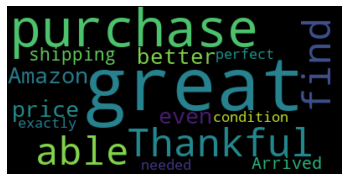

In [61]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [65]:
text_lda = lda_multicore.print_topics(num_topics=20, num_words=5)

C:\Users\timro\anaconda3\envs\NLP-S1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
wordcloud_lda = WordCloud().generate(str(text_lda))

C:\Users\timro\anaconda3\envs\NLP-S1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\timro\anaconda3\envs\NLP-S1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.5, 399.5, 199.5, -0.5)

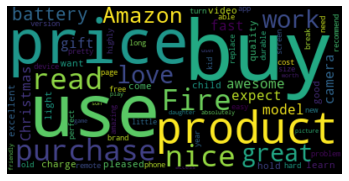

In [70]:
plt.imshow(wordcloud_lda, interpolation='bilinear')
plt.axis("off")

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling